# 전이 학습 (Transfer Learning)

In [1]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2 # OpenCV 라이브러리 → pip install opencv-python
import shutil
import numpy as np

import torch
import torchvision # cv 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
# 이미지 데이터 전처리 방법 정의
data_path = './data/catanddog/train'

transform = transforms.Compose([
                                    transforms.Resize([256,256]),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()
                               ])

train_dataset = torchvision.datasets.ImageFolder(
                                                    data_path,
                                                    transform = transform
                                                )

train_loader = torch.utils.data.DataLoader(
                                                train_dataset,
                                                batch_size = 32,
                                                num_workers = 8,
                                                shuffle = True
                                           )

print(len(train_dataset))

385


In [3]:
# RandomResizedCrop // pip install mxnet
# pip install mxnet이 에러가 나는 관계로 패스

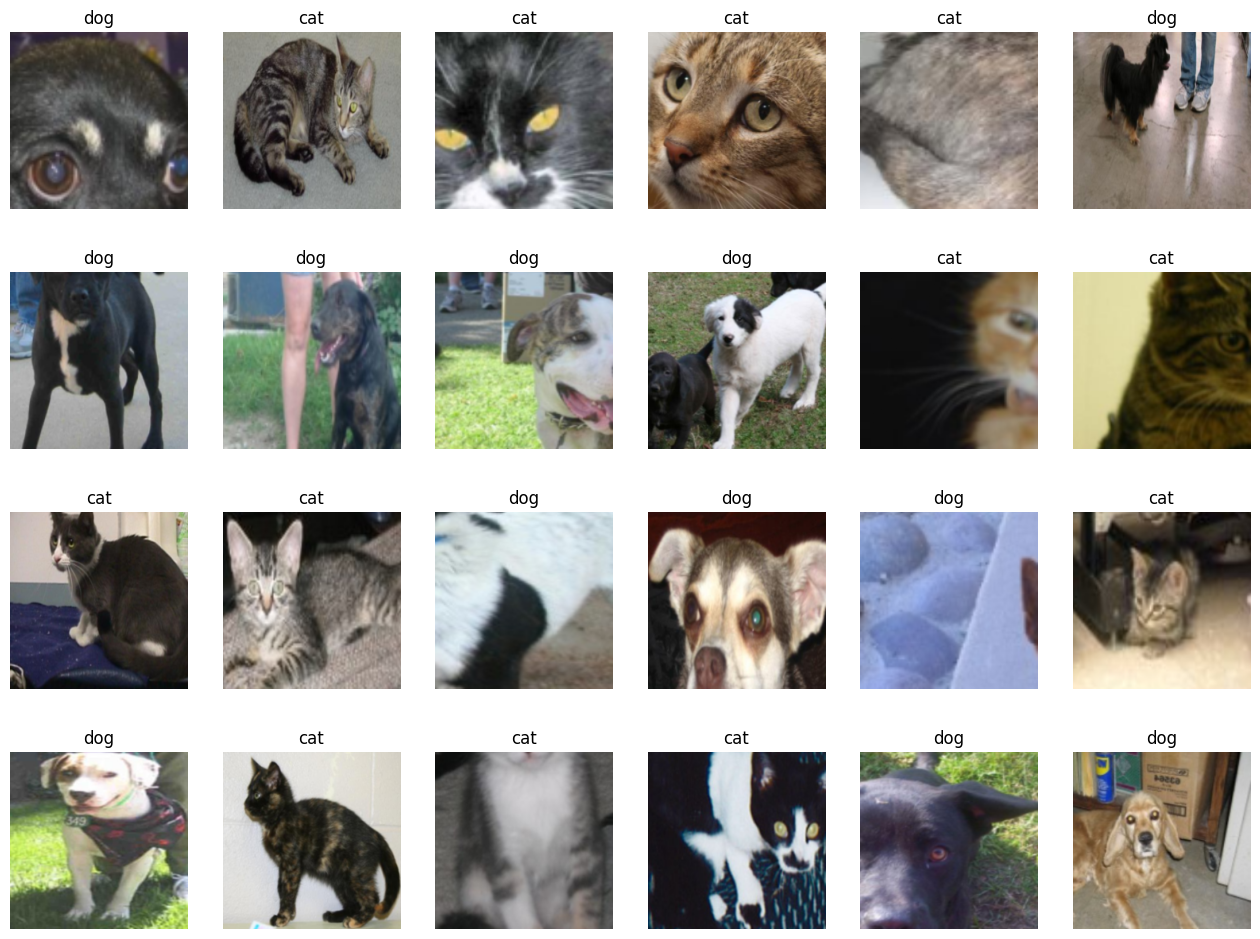

In [4]:
# 학습에 사용될 이미지 출력
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [5]:
samples

tensor([[[[0.1804, 0.1804, 0.1882,  ..., 0.2353, 0.2392, 0.2392],
          [0.1804, 0.1804, 0.1882,  ..., 0.2353, 0.2392, 0.2392],
          [0.1804, 0.1804, 0.1882,  ..., 0.2431, 0.2471, 0.2471],
          ...,
          [0.3490, 0.3490, 0.3373,  ..., 0.1765, 0.2000, 0.2039],
          [0.3843, 0.3765, 0.3451,  ..., 0.1765, 0.2000, 0.2039],
          [0.3922, 0.3843, 0.3490,  ..., 0.1765, 0.2000, 0.2039]],

         [[0.1608, 0.1608, 0.1686,  ..., 0.1882, 0.1882, 0.1882],
          [0.1608, 0.1608, 0.1686,  ..., 0.1882, 0.1882, 0.1882],
          [0.1608, 0.1608, 0.1686,  ..., 0.1922, 0.1922, 0.1922],
          ...,
          [0.3373, 0.3373, 0.3294,  ..., 0.1647, 0.1922, 0.1961],
          [0.3725, 0.3647, 0.3373,  ..., 0.1647, 0.1882, 0.1922],
          [0.3804, 0.3725, 0.3412,  ..., 0.1647, 0.1882, 0.1922]],

         [[0.1882, 0.1922, 0.2000,  ..., 0.2549, 0.2588, 0.2588],
          [0.1882, 0.1922, 0.2000,  ..., 0.2549, 0.2588, 0.2588],
          [0.1961, 0.1961, 0.2039,  ..., 0

In [6]:
samples.shape

torch.Size([32, 3, 224, 224])

In [7]:
np.transpose(samples[i].numpy(), (1,2,0)).shape

(224, 224, 3)

In [8]:
exam = np.arange(24).reshape(2, 3, 4)
exam

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [9]:
np.transpose(exam, (2,1,0))

array([[[ 0, 12],
        [ 4, 16],
        [ 8, 20]],

       [[ 1, 13],
        [ 5, 17],
        [ 9, 21]],

       [[ 2, 14],
        [ 6, 18],
        [10, 22]],

       [[ 3, 15],
        [ 7, 19],
        [11, 23]]])

In [10]:
np.transpose(exam, (2,1,0)).shape

(4, 3, 2)

In [11]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

In [12]:
# 파이토치에서 무작위의 가중치로 모델을 구성하는 방법
import torchvision.models as models

resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()

C:\Users\AIFFEL\miniconda3\envs\torch_book\lib\site-packages\torchvision\models\inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
C:\Users\AIFFEL\miniconda3\envs\torch_book\lib\site-packages\torchvision\models\googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


In [13]:
# 파이토치에서 사전 학습된 모델(사전 학습된 모델의 가중치 값) 사용
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
mnasnet = models.mnasnet1_0(pretrained=True)

In [14]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [15]:
# ResNet18에 Fully-Connected Layer추가
resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 2개 → cat, dog

In [16]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근해서 파라미터 값을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0232,  0.0409,  0.0061,  ...,  0.0274,  0.0242, -0.0406],
        [ 0.0075, -0.0289,  0.0208,  ..., -0.0370, -0.0348,  0.0163]])
fc.bias tensor([0.0028, 0.0037])


In [18]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)

for param in model.parameters():
    print(param)
    param.requires_grad=False # 모델의 합성곱층 가중치 고정
    
model.fc = torch.nn.Linear(512, 2)
for param in model.parameters(): # 완전연결층은 학습
    param.requires_grad=True
    
optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

In [19]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad() # 기울기를 0으로 설정
            outputs = model(inputs) # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 역전파 학습
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
#             print(loss.item(), inputs.size(0))
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장
            
        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산
            
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', '{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위해 저장
        print()
        
    time_elapsed = time.time() - since # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history # 모델의 정확도와 오차를 반환

In [20]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) # 파라미터 학습 결과를 저장
        print("\t", name)
        
optimizer = optim.Adam(params_to_update) # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [21]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


C:\Users\AIFFEL\miniconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 0.7479 Acc: 0.5636

Epoch 1/12
----------
Loss: 0.5022 Acc: 0.7532

Epoch 2/12
----------
Loss: 0.4039 Acc: 0.8078

Epoch 3/12
----------
Loss: 0.3066 Acc: 0.8935

Epoch 4/12
----------
Loss: 0.2596 Acc: 0.9195

Epoch 5/12
----------
Loss: 0.2408 Acc: 0.9117

Epoch 6/12
----------
Loss: 0.2169 Acc: 0.9273

Epoch 7/12
----------
Loss: 0.2238 Acc: 0.9169

Epoch 8/12
----------
Loss: 0.2346 Acc: 0.8883

Epoch 9/12
----------
Loss: 0.2169 Acc: 0.9195

Epoch 10/12
----------
Loss: 0.2303 Acc: 0.9013

Epoch 11/12
----------
Loss: 0.2062 Acc: 0.9247

Epoch 12/12
----------
Loss: 0.1847 Acc: 0.9273

Training complete in 3m 59s
Best Acc: 0.927273


In [22]:
# 테스트 데이터 호출 및 전처리
test_path = './data/catanddog/test'

transform = transforms.Compose(
                                [
                                    transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()
                                ])

test_dataset = torchvision.datasets.ImageFolder(
                                                    root = test_path,
                                                    transform = transform
)

test_loader = torch.utils.data.DataLoader(
                                            test_dataset,
                                            batch_size = 32,
                                            num_workers = 1,
                                            shuffle = True
)

print(len(test_dataset))

98


In [23]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob("./data/catanddog/" + "*.pth")
    saved_models.sort()
    print("saved model:", saved_models)
    
    for model_path in saved_models:
        print("Loading model", model_path)
        
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint)
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad(): # autograd 사용하지 않겠다는 의미
                outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장
                
            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0 # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels.cpu()).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('ACC: {:.4f}, type: {}'.format(epoch_acc, type(epoch_acc)))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        print()
            
    time_elapsed = time.time() - since
    print("Validation complete in {:.0f}m {:.0f}s0".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc: {:.4f}".format(best_acc))
    
    return acc_history

In [24]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(model, test_loader, device)

saved model: ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth
ACC: 0.5816, type: <class 'torch.Tensor'>

Loading model ./data/catanddog\01.pth
ACC: 0.8469, type: <class 'torch.Tensor'>

Loading model ./data/catanddog\02.pth
ACC: 0.9184, type: <class 'torch.Tensor'>

Loading model ./data/catanddog\03.pth
ACC: 0.9388, type: <class 'torch.Tensor'>

Loading model ./data/catanddog\04.pth
ACC: 0.9490, type: <class 'torch.Tensor'>

Loading model ./data/catanddog\05.pth
ACC: 0.9184, type: <class 'torch.Tensor'>

Loading model ./data/catanddog\06.pth
ACC: 0.9796, type: <class 'torch.Tensor'>

Loading model ./data/catanddog\07.pth
ACC: 0.9286, type

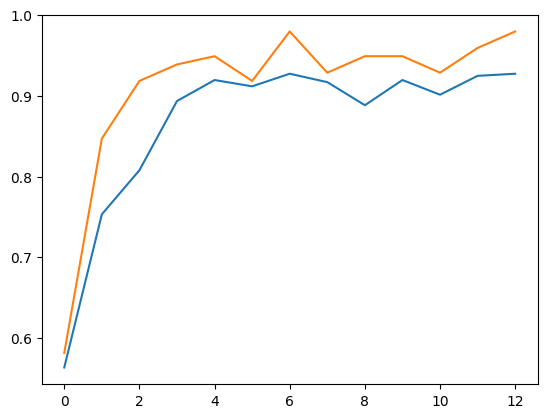

In [25]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

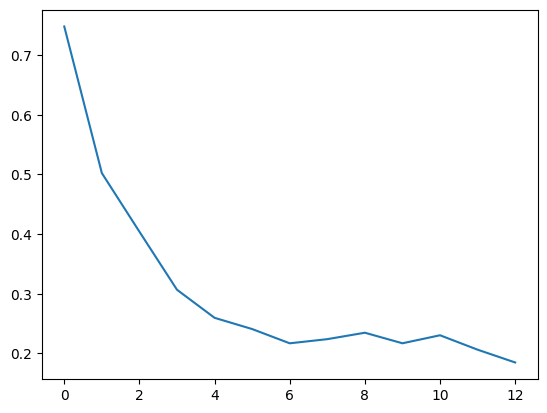

In [26]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [27]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

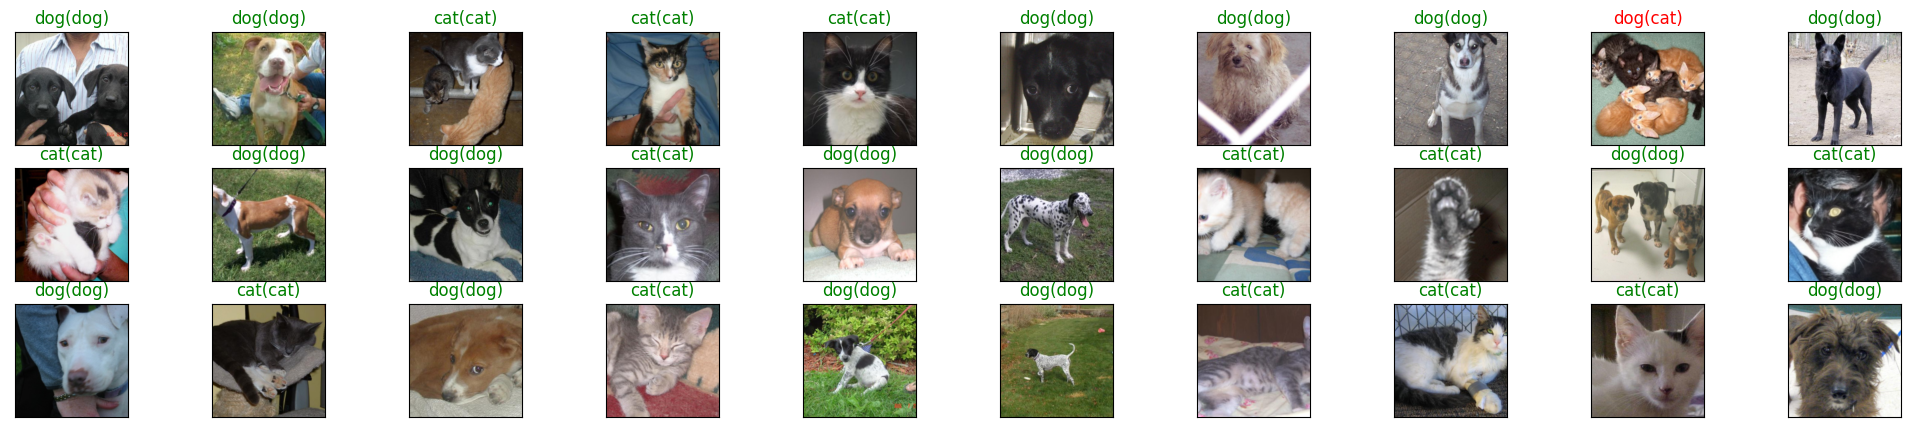

<Figure size 640x480 with 0 Axes>

In [51]:
# 강아지와 고양이 예측 결과 출력
classes = {0: 'cat', 1: 'dog'}

dataiter = iter(test_loader) # 데이터 데이터셋 가지고옴
images, labels = dataiter.next() # 테스트 데이터셋에서 이미지와 레이블 분리
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,5))
for idx in np.arange(30):
    ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx])) # 이미지 출력을 위해 im_convert함수 호출
    ax.set_title(classes[labels[idx].item()])
#     print(idx)
    ax.set_title("{}({})".format(
                                    str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                                    color=("green" if preds[idx]==labels[idx] else "red")
                                )
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [29]:
# torch.max
a = torch.randn(1, 3)
a

tensor([[-1.8739, -0.7038, -1.2266]])

In [30]:
torch.randn(3)

tensor([ 0.9043,  1.2341, -0.4249])

In [31]:
torch.max(torch.randn(3))

tensor(0.7825)

In [32]:
torch.max(a)

tensor(-0.7038)

In [33]:
torch.max(a, 1)

torch.return_types.max(
values=tensor([-0.7038]),
indices=tensor([1]))

In [34]:
aaa, bbb = torch.max(a, 1)
print(aaa, bbb)

tensor([-0.7038]) tensor([1])


In [35]:
dir(aaa)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rfloordiv__',
 '__rmul__',
 '__rpow__',
 '__rshi

In [36]:
aaa.item()

-0.703818142414093

In [37]:
aaa.values

<function Tensor.values>

In [38]:
# clip() 예시
import numpy as np
exam = np.array([-1.8, -1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
exam

array([-1.8, -1.2, -0.7,  0. ,  0.8,  1.4,  1.9])

In [39]:
np.clip(exam, -0.5, 0.5)

array([-0.5, -0.5, -0.5,  0. ,  0.5,  0.5,  0.5])

In [40]:
exam.clip(-0.5, 0.5)

array([-0.5, -0.5, -0.5,  0. ,  0.5,  0.5,  0.5])

In [41]:
np.array(0.5, 0.5, 0.5)

TypeError: array() takes from 1 to 2 positional arguments but 3 were given

In [42]:
np.array((0.5, 0.5, 0.5))

array([0.5, 0.5, 0.5])

In [43]:
print(i)

23
